# Import Packages

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

In [2]:
sys.path.append('..')
from src.config import MODEL_DIR, RAW_DIR
from src.train_model import predict_pipeline

# Import Data & Model

In [3]:
X_train = pd.read_csv(f'{MODEL_DIR}/X_train.csv')
X_test = pd.read_csv(f'{MODEL_DIR}/X_test.csv')
y_train = pd.read_csv(f'{MODEL_DIR}/y_train.csv')
y_test = pd.read_csv(f'{MODEL_DIR}/y_test.csv')
pipeline = joblib.load(f'{MODEL_DIR}/pipeline.joblib')
metrics = joblib.load(f'{MODEL_DIR}/metrics.joblib')
metrics

{'mae': {'train': 35734.86520509651, 'test': 35689.31556983785},
 'r2': {'train': 0.8654235312629017, 'test': 0.8661012935501897}}

# Quarter-on-Quarter Breakdown

In [4]:
def collect_data(X, y):
    data = (
        pd.DataFrame({
            'quarter': pd.to_datetime(X['quarter']),
            'actual': y['resale_price'],
            'pred': predict_pipeline(pipeline, X),
        })
        .assign(err=lambda x: x['pred'] - x['actual'])
        .assign(abs_err=lambda x: np.abs(x['err']))
    )
    return data

def plot_qoq(train, test, col):
    train_agg = train.groupby('quarter').agg({col:'mean'}).sort_index()
    test_agg = test.groupby('quarter').agg({col:'mean'}).sort_index()
    plt.plot(train_agg, label='train')
    plt.plot(test_agg, label='test')
    plt.xlabel('quarter')
    plt.ylabel(col)
    plt.legend()
    plt.show()

In [5]:
p_train = collect_data(X_train, y_train)
p_test = collect_data(X_test, y_test)
np.mean(p_train['abs_err']), np.mean(p_test['abs_err'])

(35734.86520509656, 35689.31556983806)

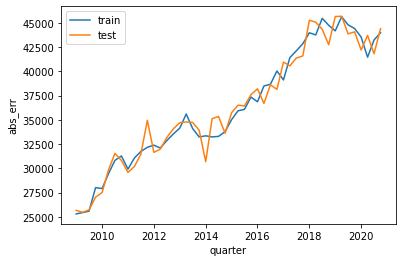

In [6]:
plot_qoq(p_train, p_test, 'abs_err')

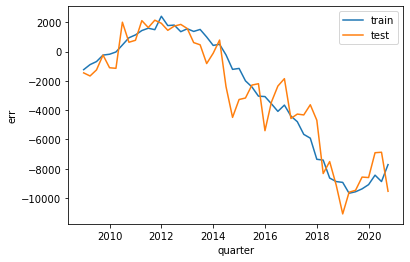

In [7]:
plot_qoq(p_train, p_test, 'err')

# Coefficients

In [8]:
coef = pd.DataFrame({
    'feature': pipeline['preprocessor'].get_feature_names(),
    'coef': pipeline['regression'].coef_[0, :],
})
coef

,feature,coef
0,onehot__x0_2009-Q2,0.005669
1,onehot__x0_2009-Q3,0.018777
2,onehot__x0_2009-Q4,0.054963
3,onehot__x0_2010-Q1,0.088973
4,onehot__x0_2010-Q2,0.127140
...,...,...
96,onehot__x3_TYPE S2,0.081550
97,onehot__x4_16 TO 30,0.107838
98,onehot__x4_>30,0.183298
99,floor_area_sqm,0.005673


In [9]:
coef[coef['feature'].str.contains('x2')]

,feature,coef
72,onehot__x2_2 ROOM,0.178904
73,onehot__x2_3 ROOM,0.380046
74,onehot__x2_4 ROOM,0.500184
75,onehot__x2_5 ROOM,0.559382
76,onehot__x2_EXECUTIVE,0.590928
77,onehot__x2_MULTI GENERATION,0.324306


# Price Index

In [10]:
my_idx = coef[coef['feature'].str.contains('x0')].reset_index(drop=True)
my_idx['quarter'] = my_idx['feature'].apply(lambda x: x.split('_')[-1])
my_idx['my_idx'] = np.round(np.exp(my_idx['coef']) * 100, decimals = 1)
my_idx = my_idx[['quarter', 'my_idx']].set_index('quarter')
my_idx.tail()

,my_idx
quarter,
2019-Q4,123.7
2020-Q1,123.5
2020-Q2,123.6
2020-Q3,125.4
2020-Q4,129.4


In [11]:
hdb_idx = pd.read_csv(f'{RAW_DIR}/hdb_index.csv')
hdb_idx = hdb_idx[['quarter', 'index']].set_index('quarter').rename(columns={'index': 'hdb_idx'})
hdb_idx.tail()

,hdb_idx
quarter,
2019-Q3,130.9
2019-Q4,131.5
2020-Q1,131.5
2020-Q2,131.9
2020-Q3,133.9


<AxesSubplot:xlabel='quarter'>

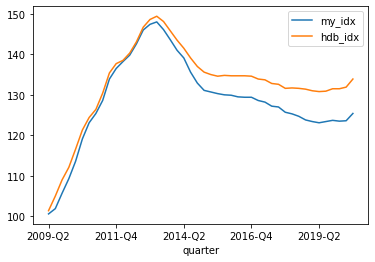

In [12]:
pd.concat([my_idx, hdb_idx], axis=1, join='inner').plot()